# 2ST & 3ST using Mach relations

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
def phi(theta, M):
    out = optimize.fsolve(lambda x: fun(x,M,theta),0.01)
    out = np.append(out, optimize.fsolve(lambda x: fun(x,M,theta),np.pi/2))
    return out
def theta(x,M):
    out = 2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    out = np.arctan(out)
    return out
def fun(x,M,theta):
    f=np.tan(theta)-2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    return f
def fun2(x,M):
    theta=np.arctan(2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2))
    return theta
def thetaMax(M):
    phi=optimize.fmin(lambda x: -fun2(x,M),0.1)
    theta=fun2(phi,M)
    return theta

class state(object):
  def __init__(self,p=100000,M=1.5,T=300,R=287,phi=0,gamma=1.4):
    self.p=p
    self.M=M
    self.T=T
    self.gamma=gamma
    self.phi=phi
    self.R=R
    self.rho=self.p/(self.R*self.T)
    self.u=self.M*np.sqrt(self.gamma*self.R*self.T)
    
def oblique(state0,theta1=10*np.pi/180,weak='True'):
  #theta=theta
  p=phi(theta1,state0.M)
  tmax=thetaMax(state0.M)
  print("Theta max :",tmax*180/np.pi)
  if tmax<theta1:
        print("Shock detached")
  else:
    if weak=='True':
      ph=p[0]
    else:
      ph=p[1]
    M1=np.sqrt((1+(state0.gamma-1)*0.5*(state0.M*np.sin(ph))**2)/(state0.gamma*(state0.M*np.sin(ph))**2-(state0.gamma-1)*0.5))/(np.sin(ph-theta1))
    p2=state0.p*(1+2*state0.gamma*((state0.M*np.sin(ph))**2-1)/(1+state0.gamma))
    T2=state0.T*(p2/state0.p)*(2+(state0.gamma-1)*(state0.M*np.sin(ph))**2)/((1+state0.gamma)*(state0.M*np.sin(ph))**2)
    state1=state(M=M1,p=p2,T=T2)
    state1.phi = ph
    state1.theta= theta1
    return state1

def ST(state0,theta1):
  state1=oblique(state0,theta1=theta1)
  if theta1<thetaMax(state1.M):
        print("This case is a Regular reflection")
        print("Solving using 2 shock theory . . .")
        state2=oblique(state1,theta1=theta1)
        return state1,state2
  else:
    print("This case is a Mach reflection")
    print("Solving for the Standard solution using 3 shock theory...")
    phi = ThreeST(state0,state1,theta1)
    phi2 = phi[0]
    phi3 = phi[1]
    theta2 = theta(phi2,state1.M)
    print(theta2*180/np.pi)
    theta3 = theta(phi3,state0.M)
    state3 = oblique(state0,theta1=theta3)
    state3.phi = phi3
    state3.theta = theta3
    state2 = oblique(state1,theta1=theta2)
    state2.phi = phi2
    state2.theta =theta2
    return state1,state2,state3

def ThreeST(state0,state1,theta):
    p = np.array([[]])
    p = np.append(p,state0.M)  # M0
    p = np.append(p,state1.M)  # M1
    p = np.append(p,theta)  # theta
    p = np.append(p,state1.p/state0.p) # p1/p0
    return optimize.fsolve(lambda x: fun3(x,p),100*np.array([0.01,0.01]))
    
def fun3(x,p,gamma = 1.4):
    """
    x[0] - phi2
    x[1] - phi3
    """
    f=np.array([])
    f=np.append(f,(1+2*(p[1]**2*np.sin(x[0])**2-1)*gamma/(gamma+1))*p[3]-(1+2*(p[0]**2*np.sin(x[1])**2-1)*gamma/(gamma+1)))
    f=np.append(f,p[2]-theta(x[0],p[1])-theta(x[1],p[0]))
    return f
    
    
def polar(state,both = 'True',type ='p', positive='True',gamma=1.4):
    tmax= thetaMax(state.M)
    theta = np.linspace(0,tmax,100)
    if type == 'p':
      pWeak = np.asarray([pRatio(k,state.M) for k in theta])
      pStrong = np.asarray([pRatio(k,state.M,weak = 'False') for k in theta])
    elif type == 'M':
      pWeak = np.asarray([Mj(k,state.M) for k in theta])
      pStrong = np.asarray([Mj(k,state.M,weak = 'False') for k in theta])
    elif type == 'rho':
      pWeak = np.asarray([rho(k,state.M) for k in theta])
      pStrong = np.asarray([rho(k,state.M,weak = 'False') for k in theta])
    elif type == 'T':
      pWeak = np.asarray([pRatio(k,state.M)/rho(k,state.M) for k in theta])
      pStrong = np.asarray([pRatio(k,state.M,weak = 'False')/rho(k,state.M,weak = 'False') for k in theta])  
    theta = np.append(theta,np.flipud(theta))
    p = np.append(pWeak,np.flipud(pStrong))
    if both =='True':
       p = np.append(p,np.flipud(p))
       theta = np.append(theta,np.flipud(-theta))
    return theta, p

def plot(theta,p,label):
    for k,j,m in zip(theta,p,label):
        plt.plot(theta[k]*180/np.pi,p[j],label=label[m])
    plt.grid()
    plt.legend(loc='best')
    plt.show()
  
   
def Mj(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    Mj=np.sqrt((1+(gamma-1)*0.5*(M*np.sin(z))**2)/(gamma*(M*np.sin(z))**2-(gamma-1)*0.5))/(np.sin(z-x))
    return Mj

def rho(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    rho=((1+gamma)*(M*np.sin(z))**2)/(2+(gamma-1)*(M*np.sin(z))**2)
    return rho    
    
def pRatio(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    p = 1+2*gamma*((M*np.sin(z))**2-1)/(1+gamma)
    return p

def pRatioMax(M):
    return optimize.fmin(lambda x: -pRatio(x,M,gamma=1.4),0.1)

In [2]:
s0=state(M=2.5,p=100000, T = 300)
t1 = 10
t2 = 10
s1u,s2u=ST(s0,theta1=t1*np.pi/180)
s1l,s2l=ST(s0,theta1=t2*np.pi/180)

Optimization terminated successfully.
         Current function value: -0.520063
         Iterations: 20
         Function evaluations: 40
Theta max : [29.79744053]
Optimization terminated successfully.
         Current function value: -0.425732
         Iterations: 20
         Function evaluations: 40
This case is a Regular reflection
Solving using 2 shock theory . . .
Optimization terminated successfully.
         Current function value: -0.425732
         Iterations: 20
         Function evaluations: 40
Theta max : [24.39263962]
Optimization terminated successfully.
         Current function value: -0.520063
         Iterations: 20
         Function evaluations: 40
Theta max : [29.79744053]
Optimization terminated successfully.
         Current function value: -0.425732
         Iterations: 20
         Function evaluations: 40
This case is a Regular reflection
Solving using 2 shock theory . . .
Optimization terminated successfully.
         Current function value: -0.425732
        

Optimization terminated successfully.
         Current function value: -0.520063
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.425732
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.425732
         Iterations: 20
         Function evaluations: 40


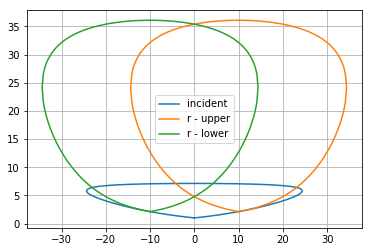

Solutions:
-0.0 degrees : 35.39835442961931
1.5902773407317584e-15 degrees : 4.776442120585028


In [3]:
import intersection 
theta0, p1 = polar(s0)
theta0, p2u = polar(s1u)
theta0, p2l = polar(s1l)
theta={1:theta0,
       2:theta0+t1*np.pi/180,
       3:theta0-t2*np.pi/180} 
p    ={1:p1,
       2:p2u*p1+-1+1*np.interp(t1*np.pi/180,theta0[:100],p1[:100]),
       3:p2l*p1+-1+1*np.interp(t2*np.pi/180,theta0[:100],p1[:100])}
label = {1: 'incident',
         2: 'r - upper',
         3: 'r - lower'}

y1 = p2u*p1+-1+1*np.interp(t1*np.pi/180,theta0[:100],p1[:100])
y2 = p2l*p1+-1+1*np.interp(t2*np.pi/180,theta0[:100],p1[:100])
plot(theta,p,label)

x,y=intersection.intersection(theta0+t1*np.pi/180,y1,theta0-t2*np.pi/180,y2)
print("Solutions:")
print(x[0]*180/np.pi, "degrees :", y[0])
print(x[1]*180/np.pi, "degrees :", y[1])

Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.676732
         Iterations: 20
         Function evaluations: 40


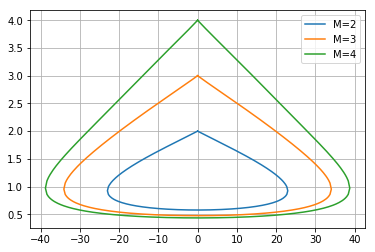

In [4]:
type = 'M'
s0=state(M=2,p=100000, T = 300)
theta0, p0 = polar(s0,type =type)
s1=state(M=3,p=100000, T = 300)
theta1, p1 = polar(s1,type =type)
s2=state(M=4,p=100000, T = 300)
theta2, p2 = polar(s2,type =type)
theta={1:theta0,
       2:theta1 ,
       3:theta2 } 
p    ={1:p0,
       2:p1,
       3:p2}
label ={1: 'M=2', 2: 'M=3',3:'M=4'}

plot(theta,p,label)

